In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Load the data:

In [3]:
import kagglehub

In [4]:
path = kagglehub.dataset_download("vishweshsalodkar/customer-feedback-dataset")
print("Path to dataset files:", path)

Path to dataset files: /Users/zakaria/.cache/kagglehub/datasets/vishweshsalodkar/customer-feedback-dataset/versions/1


In [5]:
df = pd.read_csv(f'{path}/sentiment-analysis.csv')
df.head()

,"Text, Sentiment, Source, Date/Time, User ID, Location, Confidence Score"
0,"""I love this product!"", Positive, Twitter, 202..."
1,"""The service was terrible."", Negative, Yelp Re..."
2,"""This movie is amazing!"", Positive, IMDb, 2023..."
3,"""I'm so disappointed with their customer suppo..."
4,"""Just had the best meal of my life!"", Positive..."


In [6]:
## --> The data is unstructured!

In [7]:
df = df.iloc[:, 0].str.split(',', expand=True) # 'expand=True' Returns a 'DataFrame' not a list(default mode)
df.columns = ['Text', 'Sentiment', 'Source', 'Date/Time', 'User ID', 'Location', 'Confidence Score']
df.head()

,Text,Sentiment,Source,Date/Time,User ID,Location,Confidence Score
0,"""I love this product!""",Positive,Twitter,2023-06-15 09:23:14,@user123,New York,0.85
1,"""The service was terrible.""",Negative,Yelp Reviews,2023-06-15 11:45:32,user456,Los Angeles,0.65
2,"""This movie is amazing!""",Positive,IMDb,2023-06-15 14:10:22,moviefan789,London,0.92
3,"""I'm so disappointed with their customer suppo...",Negative,Online Forum,2023-06-15 17:35:11,forumuser1,Toronto,0.78
4,"""Just had the best meal of my life!""",Positive,TripAdvisor,2023-06-16 08:50:59,foodie22,Paris,0.88


## Data preprocessing:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Text              96 non-null     object
 1   Sentiment         96 non-null     object
 2   Source            96 non-null     object
 3   Date/Time         96 non-null     object
 4   User ID           96 non-null     object
 5   Location          96 non-null     object
 6   Confidence Score  96 non-null     object
dtypes: object(7)
memory usage: 5.5+ KB


In [10]:
df.isnull().sum()

Text                2
Sentiment           2
Source              2
Date/Time           2
User ID             2
Location            2
Confidence Score    2
dtype: int64

In [11]:
df = df.dropna(subset=['Sentiment'])
df.isnull().sum()

Text                0
Sentiment           0
Source              0
Date/Time           0
User ID             0
Location            0
Confidence Score    0
dtype: int64

<Axes: xlabel='Sentiment', ylabel='count'>

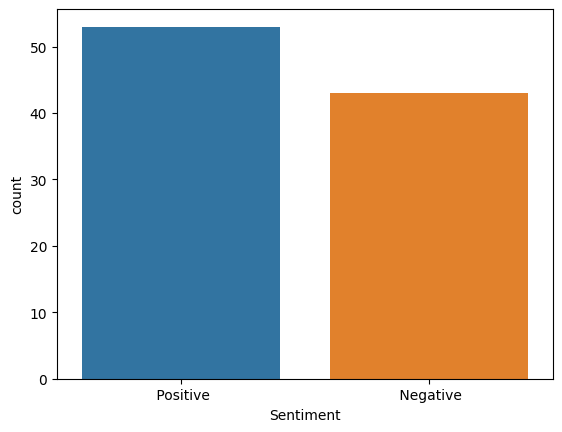

In [12]:
sns.countplot(data=df, x='Sentiment', hue='Sentiment')

In [13]:
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources 
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zakaria/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/zakaria/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/zakaria/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
## Cleaning the data:
def preprocess_text(text):
    # convert it to strings
    text = str(text)
    
    # lower the text
    text = text.lower()

    # replace everything doesn't match a lowercase or a space with ''(means: removing it)
    text = re.sub(r'[^a-z\s]', '', text)

    # remove multiple spaces
    text = ' '.join(text.split())
    
    return text

    """
        I will not use this part because it's better
        to keep stopwords when using 'Logistic Regression' model.
    """
    
    # Tokenize and remove stopwords
    #stop_words = set(stopwords.words('english'))
    #lemmatizer = WordNetLemmatizer()

    #tokens = text.split()
    #tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    #return ' '.join(tokens)

In [15]:
df['cleaned_text'] = df['Text'].apply(preprocess_text)

In [16]:
print("Original text example:", df['Text'].iloc[0])
print("Cleaned text example:", df['cleaned_text'].iloc[0])

Original text example: "I love this product!"
Cleaned text example: i love this product


## Prepare data for medeling:

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [19]:
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])

In [20]:
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['cleaned_text'])
y = df['sentiment_encoded']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build the model:

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [44]:
# Convert sparse matrix to array for neural network
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [48]:
# Build neural network
nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])

/opt/anaconda3/envs/py3-TF2.0/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [52]:
# Train the model
history = nn_model.fit(
    X_train_dense, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.4562 - loss: 0.6910 - val_accuracy: 0.3750 - val_loss: 0.7007
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5653 - loss: 0.6794 - val_accuracy: 0.3750 - val_loss: 0.6935
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6396 - loss: 0.6566 - val_accuracy: 0.5000 - val_loss: 0.6859
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6528 - loss: 0.6528 - val_accuracy: 0.5625 - val_loss: 0.6773
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7826 - loss: 0.6236 - val_accuracy: 0.5625 - val_loss: 0.6670
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7611 - loss: 0.5854 - val_accuracy: 0.5625 - val_loss: 0.6536
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7618 - loss: 0.5671 - val_accuracy: 0.5625 - val_loss: 0.6326
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9229 - loss: 0.5166 - val_accuracy: 0.6250 - val_loss: 0.6065


In [56]:
# Evaluate neural network
nn_loss, nn_accuracy = nn_model.evaluate(X_test_dense, y_test, verbose=0)
print(f"Neural Network Accuracy: {nn_accuracy:.4f}")

Neural Network Accuracy: 0.8500


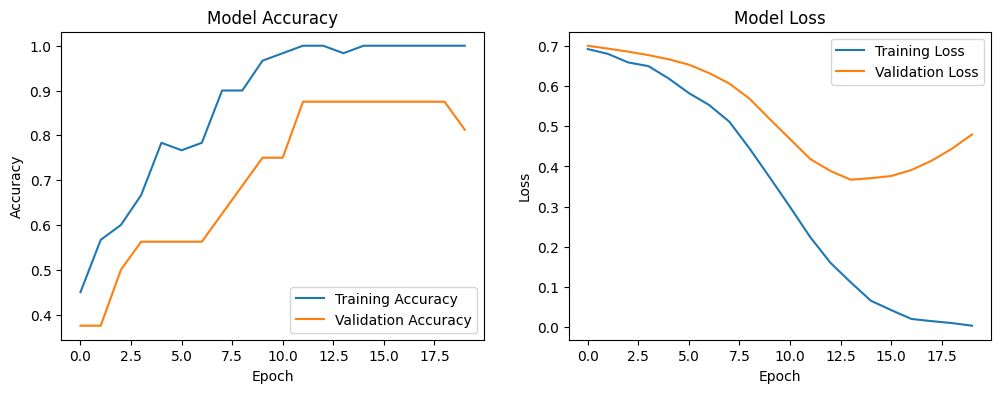

In [58]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()